In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline

In [16]:
def read_tab_sep(file):
    data = None
    with open(file, 'r') as reader:
        data = reader.readlines()[1:]
    return data

def map_to_values(utterance, reference=False):
    items = utterance.replace("\n", "").split("\t")
    
    item = None
    if reference:
        id_ = items[0]
        prompt_ = items[1]
        wavfile_ = items[2]
        transcript_ = items[3]
        language_ = items[4]
        meaning_ = items[5]
        item = {
            'id': id_,
            'prompt': prompt_,
            'wavfile': wavfile_,
            'transcript': transcript_,
            'language':language_,
            'meaning': meaning_
        }
        
    else:
        id_ = items[0]
        method_ = items[1]
        prompt_ = items[2]
        transcript_ = items[3]
        our_ = items[4]
        orig_ = items[5]
        item = {
            'id': id_,
            'method': method_,
            'prompt': prompt_,
            'transcript': transcript_,
            'our':our_,
            'original': orig_
        }
    
        
    return item

def get_items(data, reference=False):
    id_map = {}
    prompt_map = {}
    for entry in data:
        item = map_to_values(entry, reference)
        id_map[item['id']] = item
        prompt = item['prompt']
        if prompt in prompt_map:
            prompt_map[prompt].append(item)
        else:
            arr = []
            arr.append(item)
            prompt_map[prompt] = arr
    return id_map, prompt_map

In [3]:
def conf_matrix(some_id_map):
    TP = []
    TN = []
    FN = []
    FP = []
    y_true = []
    y_pred = []
    for key in some_id_map:
        item = some_id_map[key]
        if item['our'] == 'correct' and item['original'] == 'correct':
            TP.append(item)
        elif item['our'] == 'incorrect' and item['original'] == 'incorrect':
            TN.append(item)
        elif item['our'] == 'incorrect' and item['original'] == 'correct':
            FN.append(item)
        elif item['our'] == 'correct' and item['original'] == 'incorrect':
            FP.append(item)
    
        y_true.append(item['original'])
        y_pred.append(item['our'])
    
    print(accuracy_score(y_true, y_pred))
    cnf_matrix = confusion_matrix(y_true, y_pred)
    return (cnf_matrix, TP, TN, FN, FP)
    
def plot_confusion_matrix(cm, classes=['correct', 'incorrect'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        print(cm)
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Language Analytics

0.917670682731
Confusion matrix, without normalization
[[687  29]
 [ 53 227]]


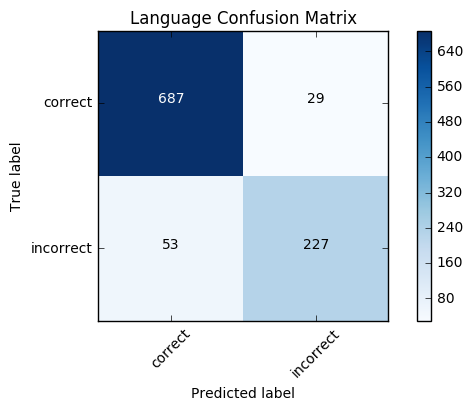

In [4]:
data = read_tab_sep('Language.tsv')
language_id_map, language_prompt_map = get_items(data)
language_returns = conf_matrix(language_id_map)
cnf_matrix = language_returns[0]
plot_confusion_matrix(cnf_matrix, normalize=False, title='Language Confusion Matrix')

# Meaning Analytics

In [5]:
data = read_tab_sep('Meaning.tsv')
meaning_id_map, meaning_prompt_map = get_items(data)


0.860441767068
Confusion matrix, without normalization
[[752 123]
 [ 16 105]]


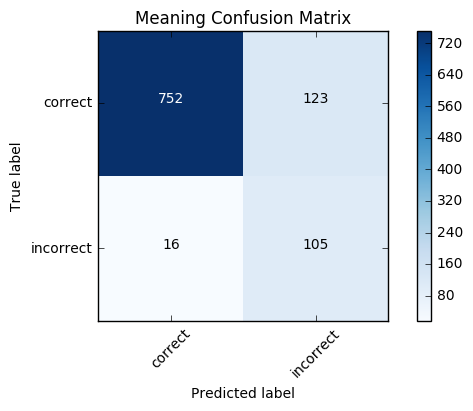

In [6]:
meaning_returns  = conf_matrix(meaning_id_map)
cnf_matrix = meaning_returns[0]
plot_confusion_matrix(cnf_matrix, normalize=False, title='Meaning Confusion Matrix')

# Judgement Analytics

In [8]:
data = read_tab_sep('Judgement.tsv')
judgement_id_map, judgement_prompt_map = get_items(data)
#actual_true_judgement = get_actual_true_of_judgement(judge)

In [9]:
judgement_returns  = conf_matrix(judgement_id_map)
cnf_matrix = judgement_returns[0]
judgement_TP = language_returns[1]
judgement_TN = language_returns[2]
judgement_FN = language_returns[3]
judgement_FP = language_returns[4]
print(len(judgement_TN))
#plot_confusion_matrix(cnf_matrix, normalize=False, title='Judgement Confusion Matrix')

0.927710843373
227


In [10]:
len(actual_true_judgement)

716

# Reference Judgement

In [33]:
def get_actual_true_of_judgement(some_id_map):
    actual_true = {}
    for key in some_id_map:
        item = some_id_map[key]
        if item['language'] == 'correct' and item['meaning'] =='correct':
            actual_true[key] = item           
    return actual_true
    

In [34]:
data = read_tab_sep('referencetest_final.csv')
reference_id_map, judgement_prompt_map = get_items(data, True)
actual_true_reference = get_actual_true_of_judgement(reference_id_map)

In [36]:
len(actual_true_reference)

716

# Metric

In [11]:
def get_plain_false_accepts():
    counter = 0
    for key in meaning_id_map:
        item = meaning_id_map[key]
        if item['our'] == 'correct':          
            language_item = language_id_map[key]
            if language_item['our'] == 'incorrect':
                counter +=1

    return counter

In [12]:
def get_gross_false_accepts():
    counter = 0
    for key in meaning_id_map:
        item = meaning_id_map[key]
        if item['our'] == 'incorrect':
            counter += 1
    return counter

In [13]:
def get_metrics(TP, TN, FN, FP):
    print("Correct accept: \t %s" % str(len(TP)))
    print("Correct reject: \t %s" % str(len(TN)))
    print("False reject: \t %s" % str(len(FN)))
    print("Plain False accept: \t %s" % str(get_plain_false_accepts()))
    PFA = None # Meaning Correct, Language Incorrect
    

get_metrics(judgement_TP, judgement_TN, judgement_FN, judgement_FP)
print(len(judgement_TN))

Correct accept: 	 687
Correct reject: 	 227
False reject: 	 29
Plain False accept: 	 38
227


In [14]:
true_meanings = get_true_meanings()

NameError: name 'get_true_meanings' is not defined

In [ ]:
true_meanings